In [1]:
!pip install scikit-learn

In [2]:
!pip install matplotlib seaborn pandas

In [3]:
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
from itertools import combinations, product

#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score, precision_score, f1_score

#graph
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:


df = pd.read_csv("/content/combine.csv")

/tmp/ipython-input-6-1614928423.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/combine.csv")


In [7]:
def clean_df(df):
    # Remove the space before each feature names
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    zero_variance_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(zero_variance_cols, axis = 1, inplace = True)
    print('zero variance columns', zero_variance_cols, 'dropped')
    print('shape after removing zero variance columns:', df.shape)

    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace = True)
    print('shape after removing nan:', df.shape)

    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    print('shape after dropping duplicates:', df.shape)

    column_pairs = [(i, j) for i, j in combinations(df, 2) if df[i].equals(df[j])]
    ide_cols = []
    for column_pair in column_pairs:
        ide_cols.append(column_pair[1])
    df.drop(ide_cols, axis = 1, inplace = True)
    print('columns which have identical values', column_pairs, 'dropped')
    print('shape after removing identical value columns:', df.shape)
    return df
df = clean_df(df)

dataset shape (2214469, 79)
zero variance columns [] dropped
shape after removing zero variance columns: (2214469, 79)
2439 rows dropped
shape after removing nan: (2212030, 79)
shape after dropping duplicates: (1941969, 79)
columns which have identical values [('Total Fwd Packets', 'Subflow Fwd Packets'), ('Total Backward Packets', 'Subflow Bwd Packets'), ('Fwd Packet Length Mean', 'Avg Fwd Segment Size'), ('Fwd PSH Flags', 'SYN Flag Count'), ('Bwd PSH Flags', 'Bwd URG Flags'), ('Bwd PSH Flags', 'Fwd Avg Bytes/Bulk'), ('Bwd PSH Flags', 'Fwd Avg Packets/Bulk'), ('Bwd PSH Flags', 'Fwd Avg Bulk Rate'), ('Bwd PSH Flags', 'Bwd Avg Bytes/Bulk'), ('Bwd PSH Flags', 'Bwd Avg Packets/Bulk'), ('Bwd PSH Flags', 'Bwd Avg Bulk Rate'), ('Fwd URG Flags', 'CWE Flag Count'), ('Bwd URG Flags', 'Fwd Avg Bytes/Bulk'), ('Bwd URG Flags', 'Fwd Avg Packets/Bulk'), ('Bwd URG Flags', 'Fwd Avg Bulk Rate'), ('Bwd URG Flags', 'Bwd Avg Bytes/Bulk'), ('Bwd URG Flags', 'Bwd Avg Packets/Bulk'), ('Bwd URG Flags', 'Bwd A

In [8]:
df['Label'].value_counts()

,count
Label,
BENIGN,1527519
DoS Hulk,172846
DDoS,128016
PortScan,90694
DoS GoldenEye,10286
DoS slowloris,5385
DoS Slowhttptest,5228
Bot,1948
Infiltration,36


In [9]:
improved_df = df

/tmp/ipython-input-10-1420663740.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subsample_df = df.groupby('Label').apply(pd.DataFrame.sample, frac = 0.1).reset_index(drop = True)


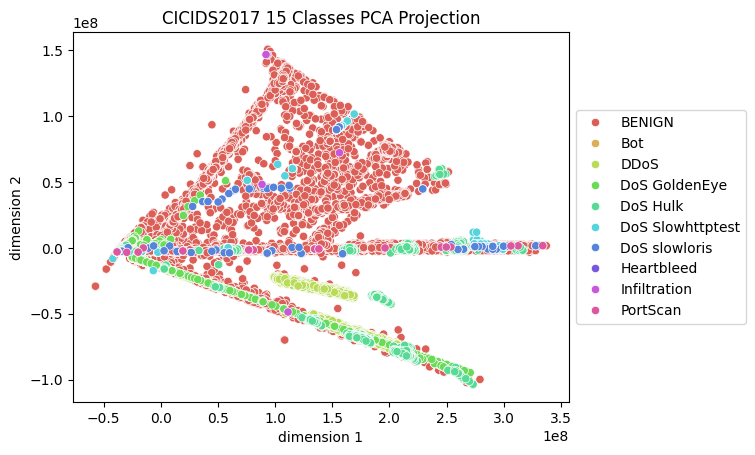

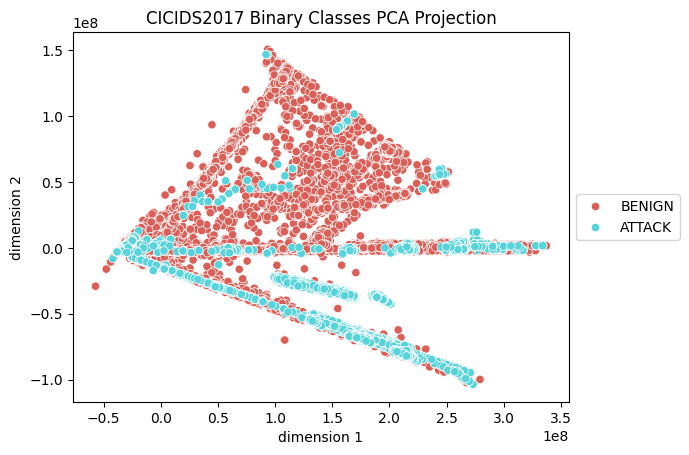

In [10]:
# https://stackoverflow.com/questions/43640952/how-to-subsample-a-pandas-dataframe-respecting-the-frequency-of-each-class
subsample_df = df.groupby('Label').apply(pd.DataFrame.sample, frac = 0.1).reset_index(drop = True)

X = subsample_df.drop(['Label'], axis = 1)
y = subsample_df['Label']

pca = PCA(n_components = 2, random_state = 0)
z = pca.fit_transform(X)

pca_15_df = pd.DataFrame()
pca_15_df['Label'] = y
pca_15_df['dimension 1'] = z[:, 0]
pca_15_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2',
                hue = pca_15_df.Label,
                palette = sns.color_palette('hls', len(pca_15_df.Label.value_counts())),
                data = pca_15_df).set(title = 'CICIDS2017 15 Classes PCA Projection')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.show()

pca_2_df = pd.DataFrame()
pca_2_df['Label'] = y
pca_2_df.loc[pca_2_df.Label != 'BENIGN', 'Label'] = 'ATTACK'
pca_2_df['dimension 1'] = z[:, 0]
pca_2_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2',
                hue = pca_2_df.Label,
                palette = sns.color_palette('hls', 2),
                data = pca_2_df).set(title = 'CICIDS2017 Binary Classes PCA Projection')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.show()

In [11]:
all_malicious = improved_df[improved_df.Label != 'BENIGN']
all_benign = improved_df[improved_df.Label == 'BENIGN']
benign_1M = all_benign.sample(n = 1000000, random_state = 0)

train_size = 500000
test_size = 500000
validation_perc = 0.15

# benign trainin and testing
Y = benign_1M['Label'].map(lambda x: 1 if (x == 'BENIGN') else -1)
labels = benign_1M['Label']

X_train, X_test, y_train, y_test = train_test_split(benign_1M.drop(columns = ['Label']),
                                                    Y,
                                                    train_size = train_size,
                                                    test_size = test_size,
                                                    shuffle = True,
                                                    stratify = Y,
                                                    random_state = 0)
train_labels, test_labels = labels.loc[y_train.index], labels.loc[y_test.index]

# validation and testing
X_mal = all_malicious.drop(columns = ['Label'])
y_mal = all_malicious['Label'].map(lambda x: 1 if (x == 'Benign') else -1)
labels_mal = all_malicious['Label']

X_test = pd.concat([X_test, X_mal])
y_test = pd.concat([y_test, y_mal])
test_labels = pd.concat([test_labels, labels_mal])

X_val, X_t, y_val, y_t, label_val, label_t = train_test_split(X_test,
                                                              y_test,
                                                              test_labels,
                                                              train_size = validation_perc,
                                                              random_state = 0,
                                                              stratify = test_labels,
                                                              shuffle = True)

print("***** Train Data *****")
print(train_labels.value_counts())
print("***** Validation Data *****")
print(label_val.value_counts())
print("***** Test Data *****")
print(label_t.value_counts())

***** Train Data *****
Label
BENIGN    500000
Name: count, dtype: int64
***** Validation Data *****
Label
BENIGN              75000
DoS Hulk            25927
DDoS                19202
PortScan            13604
DoS GoldenEye        1543
DoS slowloris         808
DoS Slowhttptest      784
Bot                   292
Infiltration            5
Heartbleed              2
Name: count, dtype: int64
***** Test Data *****
Label
BENIGN              425000
DoS Hulk            146919
DDoS                108814
PortScan             77090
DoS GoldenEye         8743
DoS slowloris         4577
DoS Slowhttptest      4444
Bot                   1656
Infiltration            31
Heartbleed               9
Name: count, dtype: int64


In [12]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Step 1: Train Isolation Forest
iso_forest = IsolationForest(n_estimators=100,
                             contamination='auto',
                             max_samples='auto',
                             random_state=0,
                             verbose=1)

iso_forest.fit(X_train)

# Step 2: Predict on validation and test sets
# Predict returns 1 for inliers, -1 for outliers
y_val_pred = iso_forest.predict(X_val)
y_test_pred = iso_forest.predict(X_t)

# Step 3: Evaluation
print("***** Validation Set Evaluation *****")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=["Malicious", "Benign"]))
print("ROC-AUC:", roc_auc_score(y_val, iso_forest.decision_function(X_val)))

print("\n***** Test Set Evaluation *****")
print(confusion_matrix(y_t, y_test_pred))
print(classification_report(y_t, y_test_pred, target_names=["Malicious", "Benign"]))
print("ROC-AUC:", roc_auc_score(y_t, iso_forest.decision_function(X_t)))


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.4s finished


***** Validation Set Evaluation *****
[[26365 35802]
 [ 5664 69336]]
              precision    recall  f1-score   support

   Malicious       0.82      0.42      0.56     62167
      Benign       0.66      0.92      0.77     75000

    accuracy                           0.70    137167
   macro avg       0.74      0.67      0.66    137167
weighted avg       0.73      0.70      0.67    137167



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


ROC-AUC: 0.7977589129280808

***** Test Set Evaluation *****
[[148923 203360]
 [ 32325 392675]]
              precision    recall  f1-score   support

   Malicious       0.82      0.42      0.56    352283
      Benign       0.66      0.92      0.77    425000

    accuracy                           0.70    777283
   macro avg       0.74      0.67      0.66    777283
weighted avg       0.73      0.70      0.67    777283



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.7s finished


ROC-AUC: 0.7990275497122884


In [16]:
X_new = X_t.copy()
joblib.dump(X_new, '/content/drive/MyDrive/X_new.pkl')


['/content/drive/MyDrive/X_new.pkl']

In [14]:
joblib.dump(scaler, 'models/scaler.pkl')

# Load scaler
scaler = joblib.load('models/scaler.pkl')

NameError: name 'scaler' is not defined

# New Section